# Fitting of TCV q-Profiles

This notebook performs polynomial and piecewise linear fits of the safety factor (q) profiles for TCV plasmas, and compares the resulting fits for q-profile, magnetic shear, and shift. The workflow includes visualization and extraction of fit coefficients for further use.

PT
double qprofile(double r, double R_axis) {
 double R = r + R_axis;
 if (R < 1.0795396185359) return 25.73868531653 * R + -25.521692682633;
 if (R >= 1.0795396185359 && R < 1.0945396185359) return 31.797637113573 * R + -32.06257119434;
 if (R >= 1.0945396185359 && R < 1.1095396185359) return 38.528000633096 * R + -39.429220713608;
 if (R >= 1.1095396185359 && R < 1.1245396185359) return 45.929775875053 * R + -47.641783592057;
 if (R >= 1.1245396185359 && R < 1.1395396185359) return 54.002962839407 * R + -56.720402181322;
 if (R >= 1.1395396185359 && R < 1.1545396185359) return 62.747561526263 * R + -66.685218833191;
 if (R >= 1.1545396185359 && R < 1.1695396185359) return 72.163571935547 * R + -77.556375899257;
 if (R >= 1.1695396185359) return 82.250994067256 * R + -89.354015731186;
}


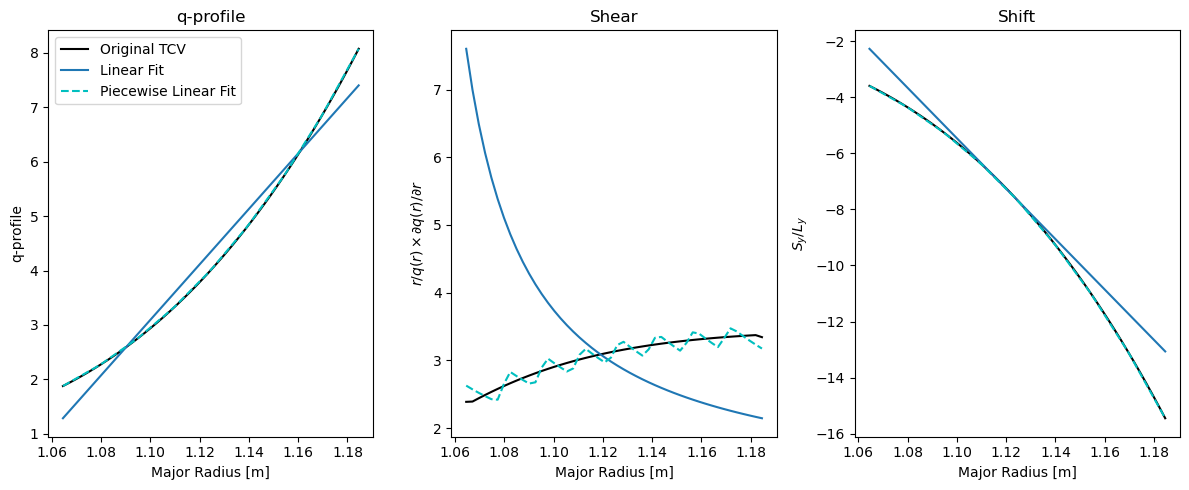

NT
double qprofile(double r, double R_axis) {
 double R = r + R_axis;
 if (R < 1.0747973082573) return 21.528778497046 * R + -21.171953767196;
 if (R >= 1.0747973082573 && R < 1.0897973082573) return 27.005109113043 * R + -27.057899172396;
 if (R >= 1.0897973082573 && R < 1.1047973082573) return 33.134922877298 * R + -33.7381537128;
 if (R >= 1.1047973082573 && R < 1.1197973082573) return 39.918219789934 * R + -41.23232188299;
 if (R >= 1.1197973082573 && R < 1.1347973082573) return 47.354999850752 * R + -49.560008177196;
 if (R >= 1.1347973082573 && R < 1.1497973082573) return 55.445263059922 * R + -58.740817090056;
 if (R >= 1.1497973082573 && R < 1.1647973082573) return 64.189009417395 * R + -68.794353115963;
 if (R >= 1.1647973082573) return 73.586238923069 * R + -79.740220749248;
}


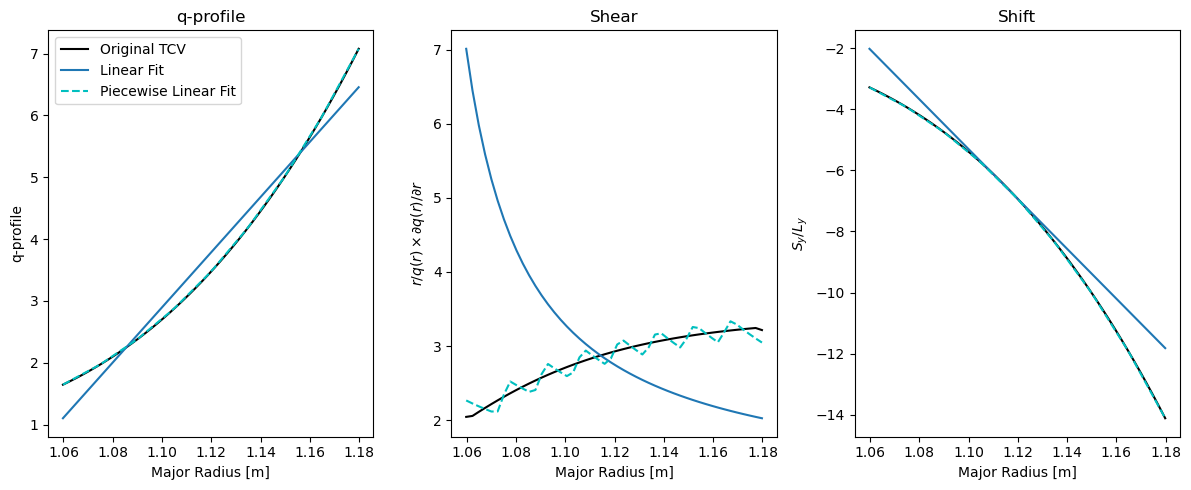

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Npieces = 8
Nx = 48

class Context:
    def __init__(self, a_shift, Z_axis, R_axis, B_axis, R_LCFSmid, x_inner, x_outer, Nx):
        self.a_shift = a_shift
        self.Z_axis = Z_axis
        self.R_axis = R_axis
        self.B_axis = B_axis
        self.R_LCFSmid = R_LCFSmid
        self.x_inner = x_inner
        self.x_outer = x_outer
        self.Rmid_min = R_LCFSmid - x_inner
        self.Rmid_max = R_LCFSmid + x_outer
        self.R0 = 0.5 * (self.Rmid_min + self.Rmid_max)
        self.a_mid = R_LCFSmid - R_axis
        self.a_mid = R_axis / a_shift - np.sqrt(R_axis * (R_axis - 2 * a_shift * R_LCFSmid + 2 * a_shift * R_axis)) / a_shift
        self.r0 = self.R0 - R_axis
        self.Lx = self.Rmid_max - self.Rmid_min
        self.x_min = 0.0
        self.x_max = self.Lx
        self.Ly = 0.2
        self.Lz = 2.0 * np.pi - 1e-10
        self.Nx = Nx

    def r_x(self, x):
        return x + self.a_mid - self.x_inner

def qprofile_TCV_PT(r, ctx):
    y = r + ctx.R_axis
    a, b, c, d = 497.3420166252413, -1408.736172826569, 1331.4134861681464, -419.00692601227627
    return (a*y**3 + b*y**2 + c*y + d)

def qprofile_TCV_NT(r, ctx):
    y = r + ctx.R_axis
    a, b, c, d = 484.0615913225881, -1378.25993228584, 1309.3099150729233, -414.13270311478726
    return (a*y**3 + b*y**2 + c*y + d)

def shear(r, qprof, ctx):
    q = qprof(r, ctx)
    dqdr = np.gradient(q, r)
    return (r/q) * dqdr

def shift(x, qprofile, ctx):
    x0 = 0.5 * (ctx.x_min + ctx.x_max)
    r0 = ctx.r_x(x0)
    q0 = qprofile(r0, ctx)
    r = ctx.r_x(x)
    return -ctx.r0 / q0 * qprofile(r, ctx) * ctx.Lz

def fit_qprofiles(r, R, qprofile_func, Npieces, ctx):
    qprofile = qprofile_func(r, ctx)
    qfit_lin = np.polyfit(R, qprofile, 1)
    qfit_quad = np.polyfit(R, qprofile, 2)
    qfit_cub = np.polyfit(R, qprofile, 3)
    def qfit_lin_func(r, ctx):
        y = r + ctx.R_axis
        return qfit_lin[0] * y + qfit_lin[1]
    def qfit_quad_func(r, ctx):
        y = r + ctx.R_axis
        return qfit_quad[0] * y**2 + qfit_quad[1] * y + qfit_quad[2]
    def qfit_cub_func(r, ctx):
        y = r + ctx.R_axis
        return qfit_cub[0] * y**3 + qfit_cub[1] * y**2 + qfit_cub[2] * y + qfit_cub[3]
    qfit_piecewise = np.zeros((Npieces, 2))
    for i in range(Npieces):
        x1 = i * (ctx.x_max - ctx.x_min) / Npieces
        x2 = (i + 1) * (ctx.x_max - ctx.x_min) / Npieces
        r1 = ctx.r_x(x1)
        r2 = ctx.r_x(x2)
        R1 = r1 + ctx.R_axis
        R2 = r2 + ctx.R_axis
        q1 = qprofile_func(r1, ctx)
        q2 = qprofile_func(r2, ctx)
        qfit_piecewise[i, 0] = (q2 - q1) / (R2 - R1)
        qfit_piecewise[i, 1] = q1 - qfit_piecewise[i, 0] * R1
    def qfit_piecewise_func(r, ctx):
        if isinstance(r, float): 
            r = np.array([r])
        y = r + ctx.R_axis
        fit = np.zeros_like(y)
        for i in range(len(y)):
            for j in range(Npieces):
                x1 = j * (ctx.x_max - ctx.x_min) / Npieces
                x2 = (j + 1) * (ctx.x_max - ctx.x_min) / Npieces
                R1 = ctx.r_x(x1) + ctx.R_axis
                R2 = ctx.r_x(x2) + ctx.R_axis
                if y[i] >= R1 and y[i] <= R2:
                    fit[i] = qfit_piecewise[j, 0] * y[i] + qfit_piecewise[j, 1]
        return fit
    return qprofile, qfit_lin_func, qfit_quad_func, qfit_cub_func, qfit_piecewise_func, qfit_lin, qfit_quad, qfit_cub, qfit_piecewise

def print_piecewise_c_code(qfit_piecewise, Npieces, ctx):
    print("double qprofile(double r, double R_axis) {")
    print(" double R = r + R_axis;")
    for i in range(Npieces):
        x1 = i * (ctx.x_max - ctx.x_min) / Npieces
        x2 = (i + 1) * (ctx.x_max - ctx.x_min) / Npieces
        r1 = ctx.r_x(x1)
        r2 = ctx.r_x(x2)
        R1 = r1 + ctx.R_axis
        R2 = r2 + ctx.R_axis
        if i == 0:
            print(" if (R < %.14g) return %.14g * R + %.14g;" % (R2, qfit_piecewise[i, 0], qfit_piecewise[i, 1]))
        elif i == Npieces - 1:
            print(" if (R >= %.14g) return %.14g * R + %.14g;" % (R1, qfit_piecewise[i, 0], qfit_piecewise[i, 1]))
        else:
            print(" if (R >= %.14g && R < %.14g) return %.14g * R + %.14g;" % (R1, R2, qfit_piecewise[i, 0], qfit_piecewise[i, 1]))
    print("}")

def plot_qprofile_comparison(R, r, x, qprofile, qprofile_func, qfit_lin_func, qfit_quad_func, qfit_cub_func, qfit_piecewise_func, ctx):
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].plot(R, qprofile, '-k', label='Original TCV')
    ax[0].plot(R, qfit_lin_func(r, ctx), '-', label='Linear Fit')
    ax[0].plot(R, qfit_piecewise_func(r, ctx), '--c', label='Piecewise Linear Fit')
    ax[0].set_xlabel('Major Radius [m]')
    ax[0].set_ylabel('q-profile')
    ax[0].set_title('q-profile')
    shear_original = shear(r, qprofile_func, ctx)
    shear_linear = shear(r, qfit_lin_func, ctx)
    ax[1].plot(R, shear_original, '-k')
    ax[1].plot(R, shear_linear, '-')
    ax[1].plot(R, shear(r, qfit_piecewise_func, ctx), '--c')
    ax[1].set_xlabel('Major Radius [m]')
    ax[1].set_ylabel(r'$r/q(r) \times \partial q(r)/\partial r$')
    ax[1].set_title('Shear')
    shift_original = shift(x, qprofile_func, ctx)/ctx.Ly
    shift_linear = shift(x, qfit_lin_func, ctx)/ctx.Ly
    ax[2].plot(R, shift_original, '-k')
    ax[2].plot(R, shift_linear, '-')
    ax[2].plot(R, shift(x, qfit_piecewise_func, ctx)/ctx.Ly, '--c')
    ax[2].set_xlabel('Major Radius [m]')
    ax[2].set_ylabel(r'$S_y/L_y$')
    ax[2].set_title('Shift')
    ax[0].legend()
    plt.tight_layout()
    plt.show()

def run_qprofile_workflow(ctx, qprofile_func):
    x = np.linspace(ctx.x_min, ctx.x_max, ctx.Nx)
    r = ctx.r_x(x)
    R = ctx.R_axis + r
    qprofile, qfit_lin_func, qfit_quad_func, qfit_cub_func, qfit_piecewise_func, qfit_lin, qfit_quad, qfit_cub, qfit_piecewise = fit_qprofiles(r, R, qprofile_func, Npieces, ctx)
    print_piecewise_c_code(qfit_piecewise, Npieces, ctx)
    plot_qprofile_comparison(R, r, x, qprofile, qprofile_func, qfit_lin_func, qfit_quad_func, qfit_cub_func, qfit_piecewise_func, ctx)

# PT context and workflow
ctx_PT = Context(
    a_shift=0.25,
    Z_axis=0.1414361745,
    R_axis=0.8727315068,
    B_axis=1.4,
    R_LCFSmid=1.0968432365089495,
    x_inner=0.04,
    x_outer=0.08,
    Nx=Nx
)
print("PT")
run_qprofile_workflow(ctx_PT, qprofile_TCV_PT)

# NT context and workflow
ctx_NT = Context(
    a_shift=0.5,
    Z_axis=0.1414361745,
    R_axis=0.8867856264,
    B_axis=1.4,
    R_LCFSmid=1.0870056099999,
    x_inner=0.04,
    x_outer=0.08,
    Nx=Nx
)
print("NT")
run_qprofile_workflow(ctx_NT, qprofile_TCV_NT)